# Text Classification:  Insults with Naive Bayes

In [88]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV as gs
import sklearn.feature_extraction.text as text
import sklearn.naive_bayes as nb
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, accuracy_score
%matplotlib inline

## Loading and preparing the data

Let's open the CSV file with `pandas`.

In [89]:
import os.path
site = 'https://raw.githubusercontent.com/gawron/python-for-social-science/master/'\
'text_classification/'
#site = 'https://gawron.sdsu.edu/python_for_ss/course_core/book_draft/_static/'
df = pd.read_csv(os.path.join(site,"troll.csv"))

Each row is a comment  taken from a blog or online forum. There are three columns: whether the comment is insulting (1) or not (0), the data, and the unicode-encoded contents of the comment.

In [7]:
df[['Insult', 'Comment']].tail()

,Insult,Comment
3942,1,"""you are both morons and that is never happening"""
3943,0,"""Many toolbars include spell check, like Yahoo..."
3944,0,"""@LambeauOrWrigley\xa0\xa0@K.Moss\xa0\nSioux F..."
3945,0,"""How about Felix? He is sure turning into one ..."
3946,0,"""You're all upset, defending this hipster band..."


Write a pandas command to create a DataFrame containing just the insults.

In [8]:
# Solution replaces df on the RHS
insult_df = df[df['Insult'] ==1].copy()

In [9]:
insult_df[:25]

,Insult,Date,Comment
0,1,20120618192155Z,"""You fuck your dad."""
7,1,NaN,"""shut the fuck up. you and the rest of your fa..."
8,1,20120502173553Z,"""Either you are fake or extremely stupid...may..."
9,1,20120620160512Z,"""That you are an idiot who understands neither..."
15,1,20120611090207Z,"""FOR SOME REASON U SOUND RETARDED. LOL. DAMN. ..."
16,1,20120320162532Z,"""You with the 'racist' screen name\n\nYou are ..."
18,1,20120320075347Z,"""your such a dickhead..."""
19,1,20120320203947Z,"""Your a retard go post your head up your #%&*"""
34,1,20120515132156Z,"""Allinit123, your\xa0hypocrisy\xa0is sickening..."
37,1,20120620161958Z,"""I can't believe the stupid people on this sit..."


In [90]:
len(insult_df)

1049

In [91]:
len(df)

3947

There are documents of a **variety** of lengths, from various kinds of social media.  From pretty long...

In [92]:
df['Comment'][79]

'"Fact : Georgia passed a strict immigration policy and most of the Latino farm workers left the area. Vidalia Georgia now has over 3000 agriculture job openings and they have been able to fill about 250 of them in past year. All you White Real Americans who are looking for work that the Latinos stole from you..Where are you ? The jobs are i Vadalia just waiting for you..Or maybe its the fact that you would rather collect unemployment like the rest of the Tea Klaners.. You scream..you complain..and you sit at home in your wife beaters and drink beer..Typical Real White Tea Klan...."'

To very very short:

In [12]:
insult_df.loc[755]

Insult                   1
Date       20120620121441Z
Comment           "Retard"
Size                     8
Name: 755, dtype: object

A look at the range.  Some very long documents have to processed and
correctly taggeda s insulting.  This is part of the challenge of this dataset.

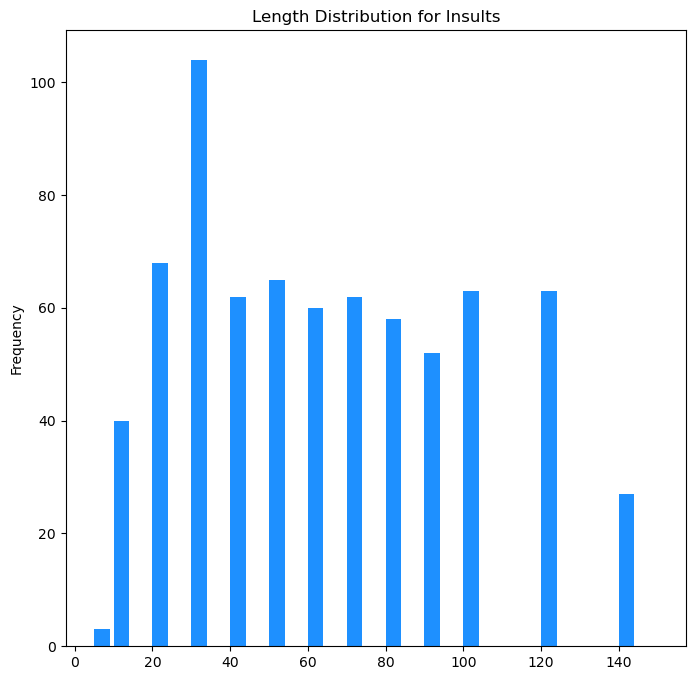

In [93]:
from matplotlib import pyplot as plt
(fig, ax) = plt.subplots(1,1,figsize=(8,8))

bar = insult_df["Size"].plot(kind="hist",bins=[5, 10, 20, 30,40, 50,60, 
                                         70, 80, 90, 100, 120,140, 150], width=4,color="dodgerblue",
                          title="Length Distribution for Insults")

## Analyzing insults with Naive Bayes: sklearn

We want to use one of the linear classifiers in `sklearn`,
but the learners in `sklearn` only work with 2D numerical arrays. 
We next discuss how to convert text into an array  of numbers.

Given a collection of documents of size D and some class labels L,
the classical solution can be described in several steps:

1. extract a **vocabulary** of size V by scanning all the texts in . Then, we build a DxV **term-document matrix** `M`.
2. For each document `d` and each word `w` fill cell `[d,w]` of `M` with a number representing the importance of word `w` in document `d`, in the simplest case, its count.  Thus one row of M represents one document in the collection. Since most documents contain only a small portion of the total vocabulary of the document collection, M is almost always **sparse**; that is, it consists almost entirely of zeros.
3. Train a classifer on the term document matrix M and class labels L.

The `sklearn` module allows us to
complete steps 1 and 2 in a few lines of code using what is called a **vectorizer**.  Step
3 is another few lines of code using a scikit learn  **classifier**. Although
there are a few things to watch out for, the same classifiers that work for other classification
problems generally work for text classification.

We first encountered a scikit learn vectorizer in the regression and classification
notebook in building an adjective classifier.  There, we were classifying words, not documents.
and the features used for classification were letter sequences from 2 to 4 characters long;
the feature values were counts of how many times a given letter sequence occurred in the word.
The Count Vectorizer learned 78,696  features, so in
the training data matrix, each word in the training data was rrepsented as
a row (or **vector**) of 78, 696 integers, most of them zero.
 
For example, the nonzero feature counts for the word "alfalfa" looked like this


```python
' a'  : 1
' al' : 1
' alf': 1
'a '  : 1
'al'  : 2
'alf' : 2
'alfa': 2
'fal' : 1
'fa'  : 2
'fa ' : 1
'falf': 1
'lfa' : 2
'lf'  : 2
'lfa ': 1
'lfal': 1
```

Based on these feature counts
the classifier computed a probability that a word was an adjective.
Although a vectorizer that measures the importance of a word
by its count is always feasible, it doesn't work as well as you might think
when the features are words.  Words counts are not very reliable 
indicators of the importance of a word because the most frequent
words (*the*, *of*, *a*) tell us nothing about what a document is about.

To represent the importance of a word in a document,  we will use a **TFIDF score**.
Although there are a metric that has had success  in a number Natural Language Processing tasks; scikit_learn
makes this `TfidfVectorizer`, 

In [ ]:
print(text.TfidfVectorizer.__doc__)

Convert a collection of raw documents to a matrix of TF-IDF features.

    Equivalent to :class:`CountVectorizer` followed by
    :class:`TfidfTransformer`.

    Read more in the :ref:`User Guide <text_feature_extraction>`.

    Parameters
    ----------
    input : {'filename', 'file', 'content'}, default='content'
        - If `'filename'`, the sequence passed as an argument to fit is
          expected to be a list of filenames that need reading to fetch
          the raw content to analyze.

        - If `'file'`, the sequence items must have a 'read' method (file-like
          object) that is called to fetch the bytes in memory.

        - If `'content'`, the input is expected to be a sequence of items that
          can be of type string or byte.

    encoding : str, default='utf-8'
        If bytes or files are given to analyze, this encoding is used to
        decode.

    decode_error : {'strict', 'ignore', 'replace'}, default='strict'
        Instruction on what to do if a b

Let's try this idea out on a very small data set:

In [94]:
from sklearn.feature_extraction.text import TfidfVectorizer
corpus = [
        'This is the first document.',
         'This document is the second document.',
         'And this is the third one.',
         'Is this the first document?',
    ]
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)
feats = vectorizer.get_feature_names_out()
print(len(feats))
print(feats)

9
['and' 'document' 'first' 'is' 'one' 'second' 'the' 'third' 'this']


So the vocabulary size is 9, so assuming this is  all the training data,
the document vectors of any future documents will be represented as vectors
of length 9.

Here is the output of `.fit_transform(...)` , a 4 x 9  term document matrix,
where 4 is the number of documents and 9 is the vocabulary size.

In [95]:
print(X.shape)
X.toarray()

(4, 9)


array([[0.        , 0.46979139, 0.58028582, 0.38408524, 0.        ,
        0.        , 0.38408524, 0.        , 0.38408524],
       [0.        , 0.6876236 , 0.        , 0.28108867, 0.        ,
        0.53864762, 0.28108867, 0.        , 0.28108867],
       [0.51184851, 0.        , 0.        , 0.26710379, 0.51184851,
        0.        , 0.26710379, 0.51184851, 0.26710379],
       [0.        , 0.46979139, 0.58028582, 0.38408524, 0.        ,
        0.        , 0.38408524, 0.        , 0.38408524]])

For each document and word the numerical value is a TFIDF score indicating the weigh/importance
of that word in that document.  In many cases that importance is 0,
indicating that word did not occur in that document.

####  Explaining TFIDF

Here are some statistics from the **British National Corpus**:

```
BNC

Corpus size   51,994,153
 Vocab size      511,928
   Num docs        1,726
```

And here are some interesting cases where word frequency
is close and document frequency  isn't:

```
social                                             18,419          1,083         
want                                               18,284          1,415         

allow                                               5,285          1,232* 
computer                                            5,262            715
treatment                                           5,250            906 
gives                                               5,258          1,191*
easily                                              5,218          1,212*
```

What we're seeing is that certain words are **burstier** than others.  Once
they occur once in a document, they are much more likely to occur
again in that same document than you'd expect given their frequency.  Take, for example,
*computer*.  Once you see this word, it's likely
that the document it occurs in has something to say about
some technical or computer-related topic, and
so the chances of seeing the word again are high.
On the other hand, consider the word *gives*, whose overall
frequency is nearly the same as *computer*.  This word
doesn't tell you nearly as much about the topic of the document
we're looking at, and the chances of seeing it again in the same document
are neither higher nor lower than you'd expect for
a word of that frequency: *computer* is bursty (it's 5K occurences are distributed
over relatively few documents); *gives* is not.

The TFIDF statistic takes into account not just the relative frequency of a word
in a document (the **Term Frequency**). It also takes into account its burstiness.  Burstiness is measured by **Inverse Document Frequency**.

The term frequency of a term in a document is just its **relative frequency** (frequency
divided by document size).  That depends on both the word and the document 


$$
(1) \; \text{tf}(t,d) = \frac{f_{t,d}}{\mid d \mid}
$$


The inverse document frquency of a term $t$ in a set of documents D
is the inverse of its relative frequency in D:

$$
(2) \; \text{idf}(t, D) = \frac{\mid D \mid}{\mid\lbrace d \mid d \in \text{D} \text{ and } t \in d  \rbrace\mid}
$$

This metric depends on the  word and document **set**.

$$
\begin{array}[t]{ll}
\text{D}   & \text{the set of  documents in the training data}\\
\mid\text{D}\mid   & \text{ the number of docs in D}\\
t          & \text{the term or word}\\
\mid\lbrace d \mid d \in \text{D} \text{ and } t \in d  \rbrace\mid &
\text{the number of documents } t \text{ occurs in }\\
\end{array}
$$

Often, instead of using IDF, what's used is the logarithm of IDF:

$$
(3) \; \text{log-idf}(t,\text{D})  = \log (\text{idf}(t, \text{D}))
$$

The expression $\log \text{idf}(t, D)$ is $- \log \text{prob}_{D}(t)$,
which in information theory is the amount of the information
gained by knowing $t$ occurs in a document in the corpus.  So TFIDF
weights the term frequency by the information value of the term.


A very popular version of TFIDF is the product of 
the log inverse document frequency and the term count.

$$
(4)\; \text{TFIDF}(t,d)  = \text{tf}(t,d)  \cdot \text{log-idf}(t, D)
$$

Just weight the term frequency of $t$ in $d$ by the information value of $t$.

The version of TFIDF used in scikit learn (also popoular) is esentially the product of 
the log inverse document frequency and the term count.

$$
(5)\; \text{TFIDF}(t,d)  = f_{t,d} \cdot \text{log-idf}(t, D)
$$

The raw term frequency is often used rather than the relative frequency
because the document vectors are going to be normalized to
unit length, so the document size will  be taken into
account, but in a slightly different way.


There are some technical details of the scikit learn implementation
discussed [here](https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)
left out of equation (5), but that's the essential idea.


Let's finish with an example.  Suppose we have a document in which
the word *given* and the word *computer* both occur 3 times.  Let's
use equation (5) and the statistics above to compute the 2 TFIDF scores:

$$
\begin{array}[t]{ll}
(a)\; \text{TFIDF}(\text{computer},d)  &= 
\begin{array}[t]{l}
3 \cdot \text{log-idf}(\text{computer}, D)\\
\log \frac{1726}{715}\\
2.64\\
\end{array}\\
(b)\; \text{TFIDF}(\text{gives},d)  & = 
\begin{array}[t]{l}
3 \cdot \text{log-idf}(\text{gives}, D)\\
\log \frac{1726}{1191}\\
1.11
\end{array}
\end{array}
$$


So as desired the occurrence of *computer* is more significant, in fact more than twice
as significant.

### Working through the insult data

Having talked through what scikit learn is going to do,  let's get back to
the insult data and demonstrate it.

In [96]:
# Split the data into training and test sets FIRST
T_train,T_test, y_train,y_test = train_test_split(df['Comment'],df['Insult'])

In [97]:
tf = text.TfidfVectorizer()
# Train your vectorizer oNLY on the trainingh data.
X_train = tf.fit_transform(T_train)

`X-train` is our **term-document** matrix. 

In [38]:
X_train.shape

(2960, 13638)

The number of columns is over 10,000.  That means our vcabulary size is over 10,000.  The actual vocabulary size of the data is a little larger, because not all of the word in the training set are being used as features.  We'll skip over the details of how those decisions are made.  For now, let's get tp the main idea.

The most important computational fact about the term-document matrix is its sparseness,
the fact that it consists mostly of 0s, because,
for any given document, most of the words in the 10,000 word vocabulary don't occur in it.

In [98]:
# Shape and Number of non zero entries
print(f'Shape: ({X_train.shape[0]:,} x {X_train.shape[1]:,})  Non-zero entries: {X_train.nnz:,}')

Shape: (2,960 x 13,787)  Non-zero entries: 75,034


Let's estimate the sparsity of this feature matrix.

In [48]:
print(("The document matrix X is ~{0:.2%} non-zero features.".format(
          X_train.nnz / float(X_train.shape[0] * X_train.shape[1]))))

The document matrix X is ~0.18% non-zero features.


In [99]:
X_train

<2960x13787 sparse matrix of type '<class 'numpy.float64'>'
	with 75034 stored elements in Compressed Sparse Row format>

The `sklearn` module stores many of its internally computed arrays as **sparse matrices**.  This is basically a 
very clever computer science device for not wasting all the space that very sparse matrices 
waste.  Natural language representations are often **quite** sparse.  The .15% non zero features
firgure we just looked at was typical.  Sparse matrices come at a cost, however; although some
computations can be done while the matrix is in sparse form, some cannot, and to do those
you have to convert the matrix to a nonsparse matrix, do what you need to do, and then, probably,
convert it back.  This is costly.  We're going to do it now, but only because we're goofing
around. Conversion to non-sparse format should in general be avoided whenever possible.

In [100]:
# Sparse matrix rep => ordinary 2D numpy array/
XA = X_train.toarray()

The number of the column that represents a word in the term document matrix is called its **encoding**.

A `TdidfVectorizer` instance stores its encoding dictionary in the attribute `vocabulary_` (note
the trailing underscore!).

Let's consider the insult word *moron*.

In [101]:
moron_ind = tf.vocabulary_['moron']
moron_ind

7295

Let's find a comment that contains 'moron' and remember its
positional index in the training data so we can look up that doc in X_train.

To make it more random, let's pick the fourth document containing "moron".

In [114]:
ctr=0
for (i,comment) in enumerate(T_train):
    if 'moron' in comment and i == 99:
        ctr += 1
        if ctr == 1:
            break

moron_comment = i
doc_i = T_train.iloc[moron_comment]
print(doc_i)

"Who is the real idiot, Dogtwon or me ? You have to pick one you know. Everybody can't be the stupidest person you talk to unless you talk to yourself. You asked for\xa0this\xa0with your lovely comments on how stupid everyone is that didn't vote for Ron Paul.What did he wind u with ? Last place\xa0and about 3 percent of the vote ? So 97 % of the other primary voters are all stupid morons and you are enlightened ?"


Ok, now we can check the TFIDF matrix for the statistic for `'moron'` in this document:

In [115]:
XA[moron_comment][moron_ind]

0.0

Wait!  That didn't work! That zero means the word *moron* doesn't occur in this document.

If you go back and look carefully at line 3 in this document, the word is actually *morons*, not *moron*.

Since our test for "moron"-documents was to use `in` directly in the document string,
it didn't distinguish occurrences of "moron" from occurrences of "morons";
"moron" is a substring of both:

```python
>>> "moron" in "you morons!"
True
```

And of course "morons" is a totally different word from *moron*, found at a totally different place in `XA`:

In [116]:
new_moron_ind = tf.vocabulary_['morons']

In [117]:
XA[moron_comment][new_moron_ind]

0.14533295914427363

The moral is that the first preprocessing step in the vectorization process is to break
a document string into a sequence of words.  This step is called **tokenization** and
it's a little more sophisticated than calling `.split()` on the document string,
but the result is similar. The bottom line is that unless you do something 
special to change things, the basic units of analysis for a document in text classification
are going to be words, not subsequences of characters as they were in our adjective example.

Summary: In this part of the discussion, we have learned about **vectorization**, the computational
process of going from a sequence of documents to a term-document matrix.

The key point is that the term document matrix is now exactly the sort of thing we used to
train classifier to recoignize iris types: a matrix whose rows reoresent exemplars
and whose columns represent features.  That mean we can just pass the the
term document matrix X_train (along with some labels) to a classifier instance to
train it.

## Training

Now, we are going to train a classifier as usual. We 
have already split the data and labels into train and test sets.

We use a **Bernoulli Naive Bayes classifier**.

In [118]:
bnb =nb.BernoulliNB()

bnb.fit(X_train, y_train)

BernoulliNB()

And we're done.  How'd we do?  Now we  test on the test set.  Before we can do that we need to
vectorize the test set.  But don't just copy what we did with the training data:

```
X_test = tf.fit_transform(T_test)
```

That would retrain the vectorizer from scratch.  Any words that occurred in the training texts
but not in the test texts would be forgotten!  Plus training the vectorizer 
is part of the classifier training pipeline.  If we let the vectorizer see
the test data during its training phase, we'd be compromising the whole
idea of splitting training and test data.  So what we want to do
with the test data is just apply the transform part of vectorizing:

```
X_test = tf.transform(T_test)
```

That is, build a representation of the test data using only the vocabulary you learned
about in training.  Ignore any new words.

In [119]:
X_test = tf.transform(T_test)
bnb.score(X_test, y_test)

0.7588652482269503

### Summarizing everything up till now

Let's summarize what we did by gathering the steps into one cell without all the discussion and re-executing it:

In [121]:
T_train,T_test, y_train,y_test = train_test_split(df['Comment'],df['Insult'])
tf = text.TfidfVectorizer()
X_train = tf.fit_transform(T_train)
bnb =nb.BernoulliNB()
bnb.fit(X_train, y_train)
X_test = tf.transform(T_test)
bnb.score(X_test, y_test)

0.7933130699088146

The result should be the same as when we stepped through it with lots of discussion, right?

Well, is it?  

Ok, re-execute the same cell above again.  Now one more time. 

Now try the following
piece of code, which wraps our classification pipeline into 
a function.

#### Basic train and test loop

In [122]:
def split_vectorize_and_fit(docs,labels,clf):
    """
    Given labeled data (docs, labels) and a classifier,
    do the training test split.  Train the vectorizer and the classifier.
    Transform the test data and return a set of preducted labels
    for the test data,
    """
    T_train,T_test, y_train,y_test = train_test_split(docs,labels)
    tf = text.TfidfVectorizer()
    X_train = tf.fit_transform(T_train)
    clf_inst = clf()
    clf_inst.fit(X_train, y_train)
    X_test = tf.transform(T_test)
    return clf_inst.predict(X_test), y_test

In [123]:
num_runs = 10
for test_run in range(num_runs):
    predicted, actual = split_vectorize_and_fit(df['Comment'],df['Insult'], nb.BernoulliNB)
    print('{0:.3f}'.format(accuracy_score(predicted, actual)))

0.753
0.757
0.762
0.779
0.750
0.771
0.751
0.764
0.784
0.769


What's happening?  

The training test split function takes a random sample of all the data to use as training data.
Each time there's a train test split we get a different classifier.  Sometimes the
training data is a better preparation for the test than others.   And so the actual
variation in performance is significant.

How should we deal this with this when we report our evaluations?
To get a realistic picture of how good our classifier is,
we need to take the average of multiple training runs, each with a different train/test split of our working
data set.

### Refined train and test loop

Explain the purpose of the code in the next cell.

In [124]:
num_runs = 100

stats = np.zeros((4,))
for test_run in range(num_runs):
    predicted, actual = split_vectorize_and_fit(df['Comment'],df['Insult'],nb.BernoulliNB)
    y_array = actual.values
    prop_insults = y_array.sum()/len(y_array)
    stats = stats + np.array([accuracy_score(predicted, actual),
                              precision_score(predicted, actual),
                              recall_score(predicted, actual),
                              prop_insults])
normed_stats = stats/num_runs
labels = ['Accuracy','Precision','Recall','Pct Insults']
for (i,s) in enumerate(normed_stats):
    print(f'{labels[i]} {s:.2f}')

Accuracy 0.76
Precision 0.14
Recall 0.89
Pct Insults 0.27


### Most important features

In this section we look at what features
are the most important in insult detection.
Despite the title of this notebook, we're not going to use
Naive Bayes; we're going to a different
classifier, because it works a little better for this
task.

For this experiment, we leave out the training test split;
in fact, we leave out anything to do with testing.

Our goal is to get a slightly better understanding of what it means to find a linear separator
in a classification setting.  We started our tour of classifiers by looking at 
iris classificstion, a simple problem with 4 features.  Now in insult detection
we have over 16,000 features.  Mathematically the only change is that
we seek a separator in 16,000 dimensions instead of 4.

But what does that that really mean?
What it boils down is that we are looking for an assignment of weights 
to all our features such that a linear combination of the weighted feature values
does the best job we can at classifying our data.  And in this
setting, whereb our features are words, that means that with the 
right kind of classifier, and the right implementation, we
can ask the classifier what features got the most wieght.
In  the case of classifying insults, that mean we can ask what
words were the most important in classifying something as an insult.

In the cell below, we give a very simple function for doing that.

In [125]:
import sklearn.svm as svm


def print_topn(vectorizer, clf, top_n=10, class_labels=(True,)):
    """Prints features with the highest coefficient values, per class"""
    feature_names = vectorizer.get_feature_names_out()
    for i, class_label in enumerate(class_labels):
        ## Look at the feature weights the classifier learned for class i.
        ## ArgSort the weights (what feature indexes have the highest weights)
        word_importance = np.argsort(clf.coef_[i])
        ## Get the topn
        top_inds = word_importance[-top_n:]
        ## What the words for the topn features
        print("%s: %s" % (class_label,
              " ".join(feature_names[j] for j in top_inds)))


tf = text.TfidfVectorizer()
X_train = tf.fit_transform(df['Comment'])
est = svm.LinearSVC()
est.fit(X_train, df['Insult'])
# Now find the most heavily weighted features [= words]
print_topn(tf,est)

True: mouth asshole faggot bitch stupid you loser moron dumb idiot



We found the words with the top 10 weights and printed them out.

They are indeed nasty insulting words.

### Running the classifier on a list of sentences

Finally, let's look at how to test our estimator on a few test sentences.

Even sentences that we've made up.

Simply be sure to transform your dat before you pass it to the predict method.

In [126]:
predicted = est.predict(tf.transform([
    "I totally agree with you",
    "You are so stupid",
    "That you are an idiot who understands neither taxation nor women\'s health."
    ]))

print(predicted)

[0 1 1]


Not bad.